In [42]:
import torchvision
from datasets import load_dataset


In [2]:
dataset_train = load_dataset('cifar10',
                            split='train',
                            ignore_verifications=False)

/home/hoseung/anaconda3/envs/hug/lib/python3.11/site-packages/datasets/load.py:2080: FutureWarning: 'ignore_verifications' was deprecated in favor of 'verification_mode' in version 2.9.1 and will be removed in 3.0.0.
You can remove this warning by passing 'verification_mode=all_checks' instead.
  warnings.warn(


In [3]:
dataset_test = load_dataset('cifar10',
                            split='test',
                            ignore_verifications=False)

/home/hoseung/anaconda3/envs/hug/lib/python3.11/site-packages/datasets/load.py:2080: FutureWarning: 'ignore_verifications' was deprecated in favor of 'verification_mode' in version 2.9.1 and will be removed in 3.0.0.
You can remove this warning by passing 'verification_mode=all_checks' instead.
  warnings.warn(


In [4]:
num_classes = len(set(dataset_train['label']))
labels = dataset_train.features['label']
num_classes, labels

(10,
 ClassLabel(names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'], id=None))

In [5]:
dataset_train[0]

{'img': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32>,
 'label': 0}

### Feature extractor

In [6]:
from transformers import ViTFeatureExtractor

In [7]:
model_name_or_path = "google/vit-base-patch16-224-in21k"

feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)

/home/hoseung/anaconda3/envs/hug/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [8]:
feature_extractor

ViTFeatureExtractor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [9]:
example = feature_extractor(
            dataset_train[0]['img'],
            return_tensors='pt') # pt = Pytorch

In [10]:
print(example)

{'pixel_values': tensor([[[[ 0.3961,  0.3961,  0.3961,  ...,  0.2941,  0.2941,  0.2941],
          [ 0.3961,  0.3961,  0.3961,  ...,  0.2941,  0.2941,  0.2941],
          [ 0.3961,  0.3961,  0.3961,  ...,  0.2941,  0.2941,  0.2941],
          ...,
          [-0.1922, -0.1922, -0.1922,  ..., -0.2863, -0.2863, -0.2863],
          [-0.1922, -0.1922, -0.1922,  ..., -0.2863, -0.2863, -0.2863],
          [-0.1922, -0.1922, -0.1922,  ..., -0.2863, -0.2863, -0.2863]],

         [[ 0.3804,  0.3804,  0.3804,  ...,  0.2784,  0.2784,  0.2784],
          [ 0.3804,  0.3804,  0.3804,  ...,  0.2784,  0.2784,  0.2784],
          [ 0.3804,  0.3804,  0.3804,  ...,  0.2784,  0.2784,  0.2784],
          ...,
          [-0.2471, -0.2471, -0.2471,  ..., -0.3412, -0.3412, -0.3412],
          [-0.2471, -0.2471, -0.2471,  ..., -0.3412, -0.3412, -0.3412],
          [-0.2471, -0.2471, -0.2471,  ..., -0.3412, -0.3412, -0.3412]],

         [[ 0.4824,  0.4824,  0.4824,  ...,  0.3647,  0.3647,  0.3647],
          [ 0

In [11]:
print(example['pixel_values'].shape)

torch.Size([1, 3, 224, 224])


### Train

In [12]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


/home/hoseung/anaconda3/envs/hug/lib/python3.11/site-packages/torch/cuda/__init__.py:107: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


### Fine-tuning

Requirements 
1. training and test dataset
2. feature extractor
3. model
4. collate function // data input 모양 맞추기 
5. evaluation metric
6. ... other training arguments

In [31]:
def collated_fn(batch):
    return {'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
            'labels': torch.tensor([x['label'] for x in batch])}

#### Evaluation metric

In [32]:
import numpy as np
import evaluate 

metric = evaluate.load("accuracy")
def compute_metrics(p):
    return metric.compute(
    predictions = np.argmax(p.predicts, axis=1),
    references=p.label_ids)

#### Training Arguments

In [33]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./cifar",
    per_device_train_batch_size=16,
    evaluation_strategy="steps",
    num_train_epochs=4,
    save_steps=100,
    eval_steps=100,
    logging_steps=10,
    learning_rate=2e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=False,
    load_best_model_at_end=True)

#### Model

In [34]:
from transformers import ViTForImageClassification

labels = dataset_train.features['label'].names

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=num_classes)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Trainer

In [35]:
dataset_train

Dataset({
    features: ['img', 'label'],
    num_rows: 50000
})

In [38]:
from transformers import AutoImageProcessor

In [39]:
image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224")

In [43]:
from torchvision.transforms import RandomResizedCrop, ColorJitter, Compose

size = (
    image_processor.size["shortest_edge"]
    if "shortest_edge" in image_processor.size
    else (image_processor.size["height"], image_processor.size["width"])
)

_transforms = Compose([RandomResizedCrop(size), ColorJitter(brightness=0.5, hue=0.5)])

In [49]:
def transforms(examples):
    images = [_transforms(img.convert("RGB")) for img in examples["img"]]
    examples["pixel_values"] = image_processor(images, do_resize=False, return_tensors="pt")["pixel_values"]
    return examples

In [50]:
dataset_train.set_transform(transforms)
dataset_test.set_transform(transforms)

In [51]:
dataset_train[0].keys()

dict_keys(['img', 'label', 'pixel_values'])

Now the dataset has "pixel_values" key required by the VIT model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


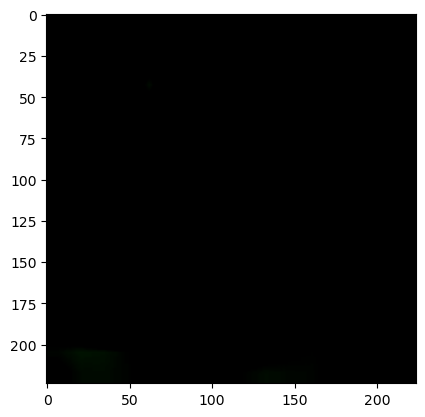

In [65]:
import numpy as np
import matplotlib.pyplot as plt

img = dataset_train[10]["pixel_values"]
plt.imshow(img.permute(1, 2, 0))

In [36]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_train,
    eval_dataset=dataset_test,
    tokenizer=feature_extractor,
    data_collator=collated_fn,
    compute_metrics=compute_metrics)
    

#### Run trainer

In [37]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

  0%|          | 0/12500 [00:00<?, ?it/s]

KeyError: 'pixel_values'

In [24]:
img = dataset_train['img'][0]

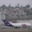

In [30]:
img